# GAN sur MNIST (TensorFlow) - Version 1

In [2]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Reshape, LeakyReLU
from tensorflow.keras.models import Sequential
import numpy as np
import matplotlib.pyplot as plt

# Charger les données MNIST
(x_train, _), (_, _) = tf.keras.datasets.mnist.load_data()
x_train = x_train.astype("float32") / 255.0
x_train = x_train.reshape(-1, 28*28)

BUFFER_SIZE = 60000
BATCH_SIZE = 128
LATENT_DIM = 100
EPOCHS = 50

train_dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)


In [3]:
# Générateur
def build_generator():
    model = Sequential([
        Dense(128, input_shape=(LATENT_DIM,), activation=LeakyReLU(0.2)),
        Dense(784, activation='sigmoid'),
        Reshape((28, 28))
    ])
    return model

# Discriminateur
def build_discriminator():
    model = Sequential([
        Flatten(input_shape=(28, 28)),
        Dense(128, activation=LeakyReLU(0.2)),
        Dense(1, activation='sigmoid')
    ])
    return model


In [4]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=False)

generator = build_generator()
discriminator = build_discriminator()

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)


In [5]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, LATENT_DIM])

    with tf.GradientTape() as disc_tape, tf.GradientTape() as gen_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        disc_loss = cross_entropy(tf.ones_like(real_output), real_output) + \
                    cross_entropy(tf.zeros_like(fake_output), fake_output)
        gen_loss = cross_entropy(tf.ones_like(fake_output), fake_output)

    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)

    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))

    return gen_loss, disc_loss


In [6]:
def train(dataset, epochs):
    for epoch in range(epochs):
        for image_batch in dataset:
            gen_loss, disc_loss = train_step(image_batch)

        if epoch % 10 == 0:
            print(f"Epoch {epoch}, Generator Loss: {gen_loss.numpy()}, Discriminator Loss: {disc_loss.numpy()}")

train(train_dataset, EPOCHS)


Epoch 0, Generator Loss: 4.031768798828125, Discriminator Loss: 0.19825635850429535
Epoch 10, Generator Loss: 2.193718433380127, Discriminator Loss: 0.43233707547187805
Epoch 20, Generator Loss: 2.0369796752929688, Discriminator Loss: 0.4825587868690491
Epoch 30, Generator Loss: 2.3593063354492188, Discriminator Loss: 0.41764211654663086
Epoch 40, Generator Loss: 2.447441577911377, Discriminator Loss: 0.4519231915473938


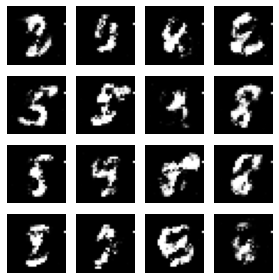

In [7]:
# Générer quelques images après entraînement
noise = tf.random.normal([16, LATENT_DIM])
generated_images = generator(noise, training=False)

plt.figure(figsize=(4,4))
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(generated_images[i, :, :], cmap='gray')
    plt.axis('off')
plt.tight_layout()
plt.show()
